# Starting point

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
# Define file paths
DATA_DIR = Path(r'.\input')
# Load data from CSV files
windgen  = pd.read_csv(DATA_DIR / 'Capacity of wind farms.csv', sep=';')
wind_cf = pd.read_excel(DATA_DIR / 'windpower.xlsx', usecols=[2])
demand  = pd.read_csv(DATA_DIR / 'Loads.csv', sep=';')
load_dist = pd.read_csv(DATA_DIR / 'ProductionConsumptionSettlement.csv', sep=';')

# Data preprocessing
windgen = windgen.values.T
wind_cf = wind_cf.apply(pd.to_numeric, errors='coerce')
demand = demand.values.T

# Select hourly data from 2023 and DK2
load_dist = load_dist[load_dist['PriceArea'] == "DK2"]
load_dist['HourUTC'] = pd.to_datetime(load_dist['HourUTC'], format='%Y-%m-%d %H:%M')
load_dist = load_dist[load_dist['HourUTC'].dt.year == 2023]
# Extract load data
load_consumption = load_dist['GrossConsumptionMWh']
load_consumption = load_consumption.str.replace(',', '.').astype(float)

# Normalize data
mean_load = load_consumption.mean()
load_consumption = load_consumption / mean_load

C:\Users\Raul_\AppData\Local\Temp\ipykernel_34272\2237202143.py:7: DtypeWarning: Columns (5,16,21,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  load_dist = pd.read_csv(DATA_DIR / 'ProductionConsumptionSettlement.csv', sep=';')


# Sampling

In [ ]:
# Generate random samples for wind power
num_samples = 2000
wind_samples = np.zeros((num_samples, windgen.shape[1]))
load_samples = np.zeros((num_samples, demand.shape[1]))

for i in range(windgen.shape[1]):
    wind_cf_sample = wind_cf.sample(n=num_samples, replace=True).values.reshape(-1, 1)
    wind_samples[:, i] = (wind_cf_sample.flatten() * windgen[0, i])

# Generate random samples for load profiles
for i in range(demand.shape[1]):
    load_consumption_sample = load_consumption.sample(n=num_samples, replace=True).values.reshape(-1, 1)
    load_samples[:, i] = (load_consumption_sample.flatten() * demand[0, i])


# Save samples to CSV file
wind_samples_df = pd.DataFrame(wind_samples, columns=[f'W{i+1}' for i in range(windgen.shape[1])])
load_samples_df = pd.DataFrame(load_samples, columns=[f'L{i+1}' for i in range(demand.shape[1])])

# Save samples to CSV file
wind_samples_df.to_csv(DATA_DIR / 'wind_samples.csv', index=False, header=True)
load_samples_df.to_csv(DATA_DIR / 'load_samples.csv', index=False, header=True)

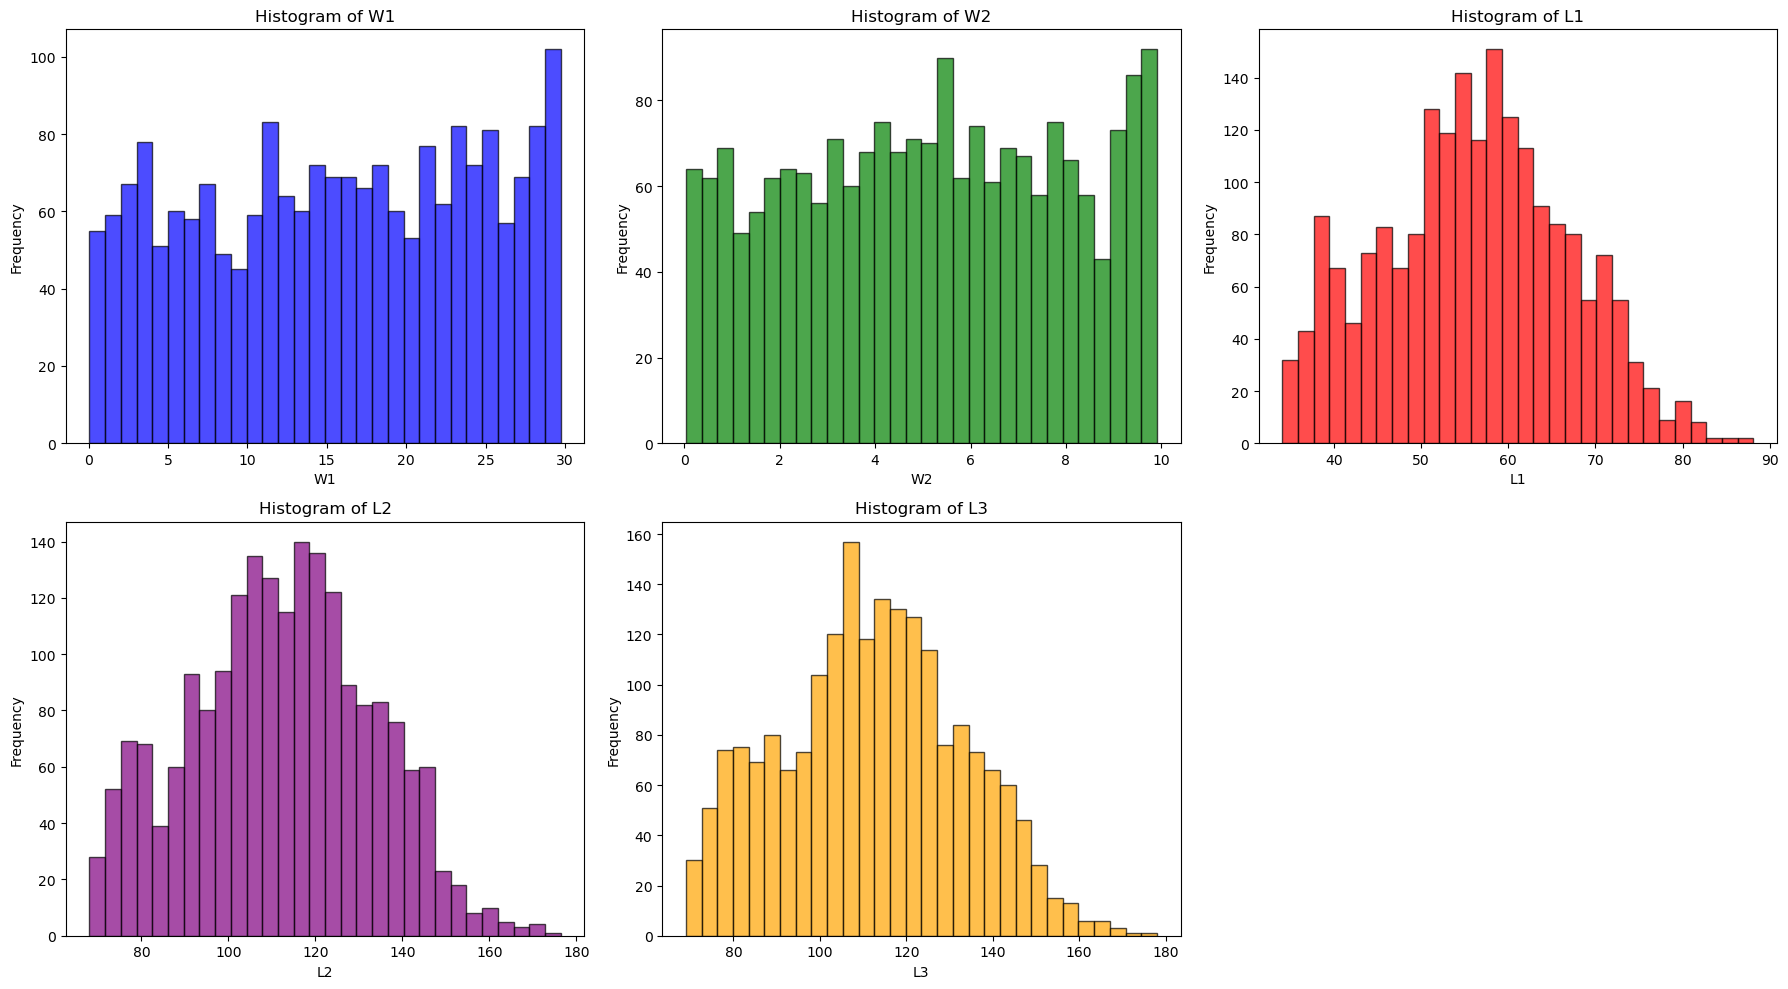

In [ ]:
# Plot histograms for the wind and load samples
plt.figure(figsize=(18, 10))

# Histogram of W1
plt.subplot(2, 3, 1)
plt.hist(wind_samples_df['W1'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of W1')
plt.xlabel('W1')
plt.ylabel('Frequency')

# Histogram of W2
plt.subplot(2, 3, 2)
plt.hist(wind_samples_df['W2'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of W2')
plt.xlabel('W2')
plt.ylabel('Frequency')

# Histogram of L1
plt.subplot(2, 3, 3)
plt.hist(load_samples_df['L1'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Histogram of L1')
plt.xlabel('L1')
plt.ylabel('Frequency')

# Histogram of L2
plt.subplot(2, 3, 4)
plt.hist(load_samples_df['L2'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Histogram of L2')
plt.xlabel('L2')
plt.ylabel('Frequency')

# Histogram of L3
plt.subplot(2, 3, 5)
plt.hist(load_samples_df['L3'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of L3')
plt.xlabel('L3')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 6-Bus Model Algorithm

In [ ]:
import gurobipy as grb
from tqdm import tqdm
import numpy as np

class BUS6:
    def __init__(self, 
        N_g, N_t, N_load, N_lines, 
        demand,
        pmin, pmax,
        Hg, Hl, fmax,
        UT, DT, ru,
        c_op, c_st,
    ):
        
        # Define numerical parameters
        self.N_g        = N_g
        self.N_t        = N_t
        self.N_load     = N_load
        self.N_lines    = N_lines

        # Define input data
        self.demand     = demand
        self.pmin       = pmin
        self.pmax       = pmax
        self.fmax       = fmax
        self.UT         = UT
        self.DT         = DT
        self.ru         = ru
        self.c_op       = c_op
        self.c_st       = c_st
        self.Hg         = Hg
        self.Hl         = Hl

    def define_decision_variables(self):
        # Add variables for each generator unit at each time step for specifying on/off and start-up status
        self.b      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='b')
        self.u      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='u')
        
        # Add variable denoting the power output of each generator unit at each time step
        self.p      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.CONTINUOUS, name='p')

        # We add slack variables for ensuring feasibility of the power balance equations
        self.eps    = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='eps')
        self.delta  = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='delta')

        # Make variable updates effective
        self.model.update()
    
    def define_constraints(self, load_profile):
        
        self.demand_profile = (self.demand * load_profile)
        
        for t in tqdm(range(self.N_t), desc='Adding constraints...'):
            ### POWER BALANCE EQUATION ###
            # Add power balance constraints for each time step
            self.model.addConstr(grb.quicksum(self.p[g_n, t] for g_n in range(self.N_g)) == grb.quicksum(self.demand_profile.iloc[t, n] for n in range(self.N_load)) + self.eps[t, 0] - self.delta[t, 0], name=f'power_balance[{t}]')
            
            # Add positive constraints for the slack variables
            self.model.addConstr(self.eps[t, 0] >= 0)
            self.model.addConstr(self.delta[t, 0] >= 0)

            for g in range(self.N_g):
                
                ### GENERATION LIMITS ###
                self.model.addConstr(self.b[g, t] * self.pmin.iloc[g, 0] <= self.p[g, t], name=f'generation_limit[{g},{t}]')
                self.model.addConstr(self.b[g, t] * self.pmax.iloc[g, 0] >= self.p[g, t], name=f'generation_limit[{g},{t}]')
                
                if t >= 1:
                    ### GENERATOR ON/OFF AND START-UP STATUS ###
                    self.model.addConstr(self.u[g, t] >= self.b[g, t] - self.b[g, t-1], name=f'start_up_constraint[{g},{t}]')

                    ### RAMPING CONSTRAINTS ###
                    self.model.addConstr(self.p[g, t] - self.p[g, t-1] <= self.ru.iloc[g, 0], name=f'ramping_up[{g},{t}]')
                    self.model.addConstr(self.p[g, t-1] - self.p[g, t] <= self.ru.iloc[g, 0], name=f'ramping_down[{g},{t}]')

                    ### MINIMUM ON TIME ###
                    min_on_time_generator = min(self.UT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_on_time_generator):
                        self.model.addConstr(-self.b[g, t-1] + self.b[g, t] - self.b[g, tau] <= 0, name=f'min_on_time_constraint[{g},{t},{tau}]')
                    
                    ### MINIMUM OFF TIME ###
                    min_off_time_generator = min(self.DT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_off_time_generator):
                        self.model.addConstr(self.b[g, t-1] - self.b[g, t] + self.b[g, tau] <= 1, name=f'min_off_time_constraint[{g},{t},{tau}]')
                                
            ### LINE FLOW LIMITS ###
            for l in range(self.N_lines):
                line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g))
                line_expr2  = grb.LinExpr(np.dot(self.Hl.iloc[l, :], self.demand_profile.iloc[t, :]))
                line_expr   = line_expr1 - line_expr2 - self.eps[t, 0] + self.delta[t, 0]

                line_max = self.fmax.iloc[l].item()
                # LHS
                self.model.addLConstr(line_expr <= line_max, name=f'pos_line_flow_limit[{l},{t}]')
                # RHS
                self.model.addLConstr(-line_max <= line_expr, name=f'neg_line_flow_limit[{l},{t}]')
  
        self.model.update()
    
    def define_objective(self, M: int = 1):
        # Set minimization objective function
        minimum_objective   = grb.quicksum(self.c_op.iloc[g, 0] * self.p[g, t] + self.c_st.iloc[g, 0] * self.u[g, t] for g in range(self.N_g) for t in range(self.N_t))
        # Set slack objective function
        slack_objective     = M * grb.quicksum(self.eps[t, 0] + self.delta[t, 0] for t in range(self.N_t))

        # Set objective function
        self.model.setObjective(sense=grb.GRB.MINIMIZE, expr=minimum_objective + slack_objective)
        self.model.update()

    def setup_model(self, load_profile, M: int = 1000):
        # Set up optimization model
        self.model = grb.Model()
        self.define_decision_variables()
        self.define_constraints(load_profile)
        self.define_objective(M=M)

    def optimize(self, load_profile, M: int = 1000):
        # Initialize model
        self.setup_model(load_profile, M)
        # Run optimization
        return self.model.optimize()

# Optimization calculation

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# Agregar el directorio del archivo bus6.py al PYTHONPATH
sys.path.append(r'C:\Users\Raul_\OneDrive\ドキュメント\7. Máster\5. Autum 2024\46765 - Machine learning for energy systems\Assignment\Assignment 2')
from bus6 import BUS6  # Importa la clase BUS6 directamente


# Define las nuevas rutas de los archivos de datos
DATA_DIR = Path(r'C:\Users\Raul_\OneDrive\ドキュメント\7. Máster\5. Autum 2024\46765 - Machine learning for energy systems\Assignment\Assignment 2\Input')
SAVE_DIR = DATA_DIR / 'processed'
os.makedirs(SAVE_DIR, exist_ok=True)

# Carga los archivos de datos desde los archivos CSV
pmax    = pd.read_csv(DATA_DIR / 'Maximum production of generating units.csv')
pmin    = pd.read_csv(DATA_DIR / 'Minimum production of generating units.csv')
ru      = pd.read_csv(DATA_DIR / 'Ramping rate of generating units.csv')
UT      = pd.read_csv(DATA_DIR / 'Minimum up time of generating units.csv')
DT      = pd.read_csv(DATA_DIR / 'Minimum down time of generating units.csv')    
demand  = pd.read_csv(DATA_DIR / 'Loads.csv', sep=';')   
c_op    = pd.read_csv(DATA_DIR / 'Production cost of generating units.csv') 
c_st    = pd.read_csv(DATA_DIR / 'Start-up cost of generating units.csv') 
PTDF    = pd.read_csv(DATA_DIR / 'Transmission capacity of lines.csv', sep=';') 
busgen  = pd.read_csv(DATA_DIR / 'Capacity of wind farms.csv', sep=';')
busload = demand  # Usa el mismo archivo para busload
fmax    = pd.read_csv(DATA_DIR / 'Transmission capacity of lines.csv')

# Verificar las dimensiones de PTDF y busgen
print(f"PTDF shape: {PTDF.shape}")
print(f"busgen shape: {busgen.shape}")

# Asegurarse de que las dimensiones sean compatibles
if PTDF.shape[1] != busgen.shape[0]:
    raise ValueError(f"Las dimensiones de PTDF y busgen no son compatibles para la multiplicación de matrices: {PTDF.shape[1]} != {busgen.shape[0]}")

# PTDF
Hg = pd.DataFrame(np.dot(PTDF, busgen.T), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Gen {i+1}' for i in range(busgen.shape[1])])
Hl = pd.DataFrame(np.dot(PTDF, busload.T), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Load {i+1}' for i in range(busload.shape[1])])

# Cargar muestras de perfiles de carga
samples = pd.read_csv(DATA_DIR / 'samples.csv', header=None)

# Establecer variables globales del sistema
N_g     = busgen.shape[1]   # el número de unidades generadoras
N_t     = demand.shape[0]   # las próximas 24 horas
N_load  = busload.shape[1]  # el número de buses de carga
N_lines = PTDF.shape[0]     # el número de líneas de transmisión


if __name__ == '__main__':

    # ESPECIFICAR LAS MUESTRAS A EJECUTAR
    start_sample_idx    = 0
    end_sample_idx      = 2000

    # Importar la clase del sistema
    system = BUS6(  # Cambia la clase a BUS6
        N_g=N_g, N_t=N_t, N_load=N_load, N_lines=N_lines,
        demand=demand,
        pmin=pmin, pmax=pmax,
        Hg=Hg, Hl=Hl, fmax=fmax,
        UT=UT, DT=DT, ru=ru,
        c_op=c_op, c_st=c_st,
    )

    # Crear un bucle interno para ejecutar y guardar los datos
    for i in tqdm(range(start_sample_idx, end_sample_idx, 1)):

        # Seleccionar un perfil de carga
        load_profile = samples.iloc[i, :].values[np.newaxis, :]

        # Optimizar el sistema con el perfil de carga especificado
        opt = system.optimize(load_profile, M=1000)

        # Preparar el formato de datos para los resultados
        on_off      = -1 * np.ones((system.N_g, system.N_t))
        start_up    = -1 * np.ones((system.N_g, system.N_t))

        # Extraer resultados
        for t in range(24):
            for g in range(N_g):
                # Resultados dependientes del generador
                on_off[g, t]    = system.b[g, t].x
                start_up[g, t]  = system.u[g, t].x

        # Para alguna razón, algunos ceros tienen un menos delante - tomar el valor absoluto no cambia el valor, solo la apariencia visual de la matriz
        on_off      = pd.DataFrame(abs(on_off),     columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
        start_up    = pd.DataFrame(abs(start_up),   columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])

        constraints = pd.DataFrame([{
            'constr_type': c.ConstrName.split('[')[0] if '[' in c.ConstrName else c.ConstrName, 
            'constr_level': '[' + c.ConstrName.split('[')[1] if '[' in c.ConstrName else '-', 
            'constraint_slack': c.Slack, 
            'rhs': c.getAttr('rhs')
        } for c in system.model.getConstrs()])

        grouped_constraints = {}
        for name in tqdm(constraints['constr_type'].unique()):
            grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

        pos_line_flow_limits            = grouped_constraints['pos_line_flow_limit']
        pos_line_flow_limits['l']       = pos_line_flow_limits['constr_level'].apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
        pos_line_flow_limits['t']       = pos_line_flow_limits['constr_level'].apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))
        pos_line_flow_limits['active']  = (abs(pos_line_flow_limits['constraint_slack']) < 1e-3).astype(int)

        neg_line_flow_limits            = grouped_constraints['neg_line_flow_limit']
        neg_line_flow_limits['l']       = neg_line_flow_limits['constr_level'].apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
        neg_line_flow_limits['t']       = neg_line_flow_limits['constr_level'].apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))
        neg_line_flow_limits['active']  = (abs(neg_line_flow_limits['constraint_slack']) < 1e-3).astype(int)

        # Extraer como dataframe
        pos_active_lines                = pd.pivot_table(pos_line_flow_limits, index='t', columns='l', values='active', aggfunc='sum')
        pos_active_lines.columns        = [f'Line {i+1}' for i in range(system.N_lines)]
        pos_active_lines.index          = [f'Hour {i+1}' for i in range(system.N_t)]
        # Extraer como dataframe
        neg_active_lines                = pd.pivot_table(neg_line_flow_limits, index='t', columns='l', values='active', aggfunc='sum')
        neg_active_lines.columns        = [f'Line {i+1}' for i in range(system.N_lines)]
        neg_active_lines.index          = [f'Hour {i+1}' for i in range(system.N_t)]

        # Guardar los resultados
        on_off.to_csv(SAVE_DIR / f'on_off_{start_sample_idx}_{end_sample_idx}.csv', index=False, header=False, mode='a')
        start_up.to_csv(SAVE_DIR / f'start_up_{start_sample_idx}_{end_sample_idx}.csv', index=False, header=False, mode='a')
        pos_active_lines.to_csv(SAVE_DIR / f'active_pos_lineflow_{start_sample_idx}_{end_sample_idx}.csv', index=False, header=False, mode='a')
        neg_active_lines.to_csv(SAVE_DIR / f'active_neg_lineflow_{start_sample_idx}_{end_sample_idx}.csv', index=False, header=False, mode='a')

PTDF shape: (7, 1)
busgen shape: (2, 1)


ValueError: Las dimensiones de PTDF y busgen no son compatibles para la multiplicación de matrices: 1 != 2